# Runge-Kutta methods and higher-order ODEs

Runge-Kutta methods are a broad class of useful ODE solvers. In this notebook we look at a few of them, their convergence rates, and how to apply them to second-order equations

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# The below commands make the font and image size bigger
plt.rcParams.update({'font.size': 22})
plt.rcParams["figure.figsize"] = (15,10)

We will define an `ODESolve` function that can use different methods. First let's define the stepping functions for the Euler, RK2 and RK4 methods.

In [2]:
def EulerStep(f, dx, xi, yi):
    return yi + dx*f(xi, yi)

In [3]:
def RK2Step(f, dx, xi, yi):
    k1 = dx*f(xi, yi)
    k2 = dx*f(xi + dx, yi + k1)
    
    return yi + 0.5*(k1 + k2)

In [4]:
def RK4Step(f, dx, xi, yi):
        k1 = dx*f(xi,yi)
        k2 = dx*f(xi + 0.5*dx, yi + 0.5*k1)
        k3 = dx*f(xi + 0.5*dx, yi + 0.5*k2)
        k4 = dx*f(xi + dx, yi + k3)
        
        return yi + 1/6*(k1 + 2*k2 + 2*k3 + k4)

The method in the below function can be set using the optional 6th argument.

In [5]:
def ODESolve(f, dx, x0, y0, imax, method='RK4', plotSteps=False):
    
    xi = x0
    yi = y0
    
    # Create arrays to store the steps in
    steps = np.zeros((imax+1,2))
    steps[0,0] = x0
    steps[0,1] = y0
    
    i = 0
    while i < imax:
        if(method == 'RK4'):
            yi = RK4Step(f, dx, xi, yi)
        elif(method == 'RK2'):
            yi = RK2Step(f, dx, xi, yi)
        elif(method == 'Euler'):
            yi = EulerStep(f, dx, xi, yi)
        
        xi += dx
        i  += 1
        
        # Store the steps for plotting
        steps[i, 0] = xi
        steps[i, 1] = yi  
        
    if(plotSteps):
        plt.scatter(steps[:,0], steps[:,1], color='red', linewidth='10')
        
    return [xi, yi]

In [6]:
def dydx(x,y):
    return -2*x - y

In [7]:
def yExact(x):
    return - 3*np.exp(-x) - 2*x + 2

[0.5, -0.821227295946875]

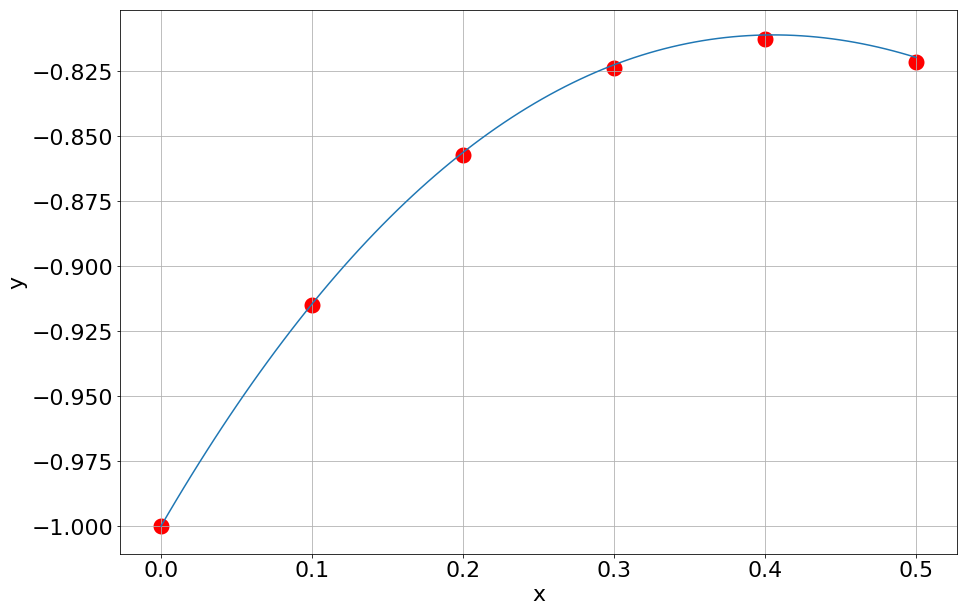

In [12]:
x = np.linspace(0, 0.5, 100)
y = yExact(x)
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.plot(x,y)

ODESolve(dydx, 0.1, 0, -1, 5, 'RK2', True)

## Convergence of the methods
Let's look at the rate of convergence of the three methods: Euler, RK2 and RK4

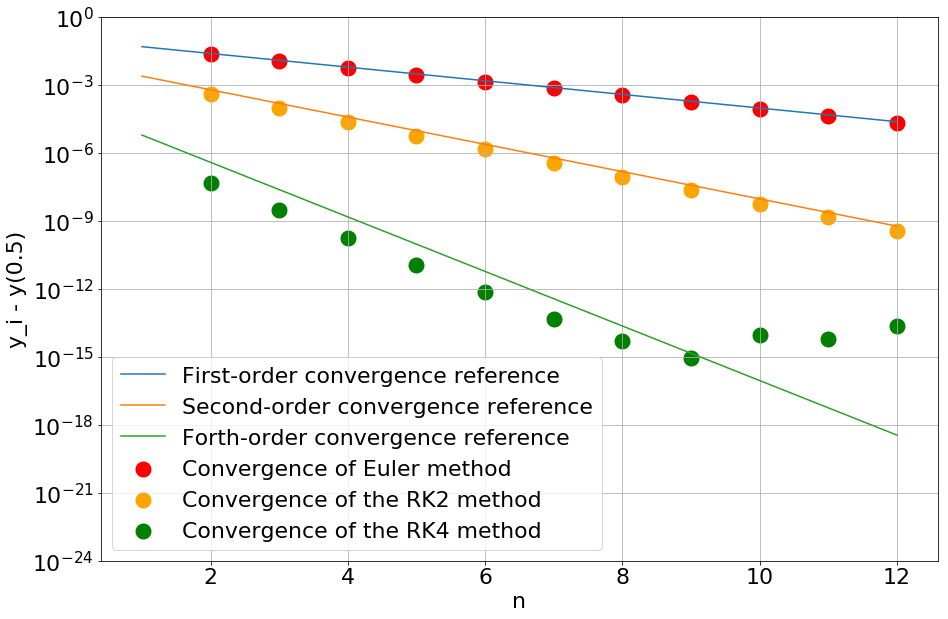

In [148]:
nmax = 12

diffEuler = np.zeros(nmax)
diffRK2 = np.zeros(nmax)
diffRK4 = np.zeros(nmax)

n = 1
while n < nmax:
    deltax       = 0.1/2**n
    nsteps       = 5*2**n
    resEuler     = ODESolve(dydx, deltax, 0, -1, nsteps, 'Euler')
    resRK2       = ODESolve(dydx, deltax, 0, -1, nsteps, 'RK2')
    resRK4       = ODESolve(dydx, deltax, 0, -1, nsteps, 'RK4')
    
    diffEuler[n] = np.abs(resEuler[1] - yExact(0.5))
    diffRK2[n]   = np.abs(resRK2[1] - yExact(0.5))
    diffRK4[n]   = np.abs(resRK4[1] - yExact(0.5))
    n += 1
    
# Plot the results
plt.grid(True)
plt.yscale('log')
plt.xlabel('n')
plt.ylabel('y_i - y(0.5)')
plt.ylim([1e-24, 1])

# Compute and plot reference curves for the convergence rate
x           = np.linspace(1, nmax, 12)
deltax      = (0.1/2**x)
firstOrder  = deltax**1
secondOrder = deltax**2
forthOrder  = deltax**4

plt.plot(x, firstOrder)
plt.plot(x, secondOrder)
plt.plot(x, forthOrder)

plt.scatter(np.arange(1,nmax+1), diffEuler, color='red', linewidth='10')
plt.scatter(np.arange(1,nmax+1), diffRK2, color='orange', linewidth='10')
plt.scatter(np.arange(1,nmax+1), diffRK4, color='green', linewidth='10')

plt.legend(['First-order convergence reference', 
            'Second-order convergence reference', 
            'Forth-order convergence reference',
            'Convergence of Euler method', 
            'Convergence of the RK2 method',
            'Convergence of the RK4 method'
           ]);

Thus we see that the RK4 method is rapidly convergent. It does require 4 evaluations of the right-hand side of the equations. The RK4 method has a good balance between between taking the least number of steps and achieving the highest accuracy.

## Second-order ODEs

As we discussed in the lectures we can write any an $n^\text{th}$-order ODE as a coupled system of $n$ first-order ODEs. Let's look at implementing it in practice. 

Let's consider a second-order ODE. We want to write this in the form:

$$\begin{align}
    y_0'(x) &= f_0(x, y_0, y_1)\\
    y_1'(x) &= f_1(x, y_0, y_1)
\end{align}$$

We thus want to write a function that when passed $x$ and an array $\textbf{y} = [y_0, y_1]$ returns an array $\textbf{f} = [f_0, f_1]$. Let's look at a specific example. Consider $y''(x) = -y$ with $y(0) = 1$. This has the analytic solution $y(x) = \cos(x)$. Let's write this in first-order form. 

Let $y_0(x) = y(x)$ and $y_1 = y_0'(x)$. Then we have $y_1' = -y_0$. Thus

$$\begin{align}
    y_0'(x) &= y_1\\
    y_1'(x) &= -y_0
\end{align}$$

so $\textbf{f} = [y_1, -y_0]$. Let's define a Python function for this.

In [12]:
def f2(x, y):
    return np.array([y[1], -y[0]])

In [13]:
def SecondOrderRK2(f, dx, x0, y0, imax):
    output = np.empty((imax, 3))
    i = 0
    xi = x0
    yi = y0
    while(i < imax):
        k1 = dx*f(xi, yi)
        k2 = dx*f(xi + dx, yi + k1)
        yi = yi + 0.5*(k1 + k2)
        xi += dx
        output[i, 0] = xi
        output[i, 1] = yi[0]
        output[i, 2] = yi[1]
        i += 1
    return output

In [14]:
res = SecondOrderRK2(f2, 0.1, 0, [1,0], 200);

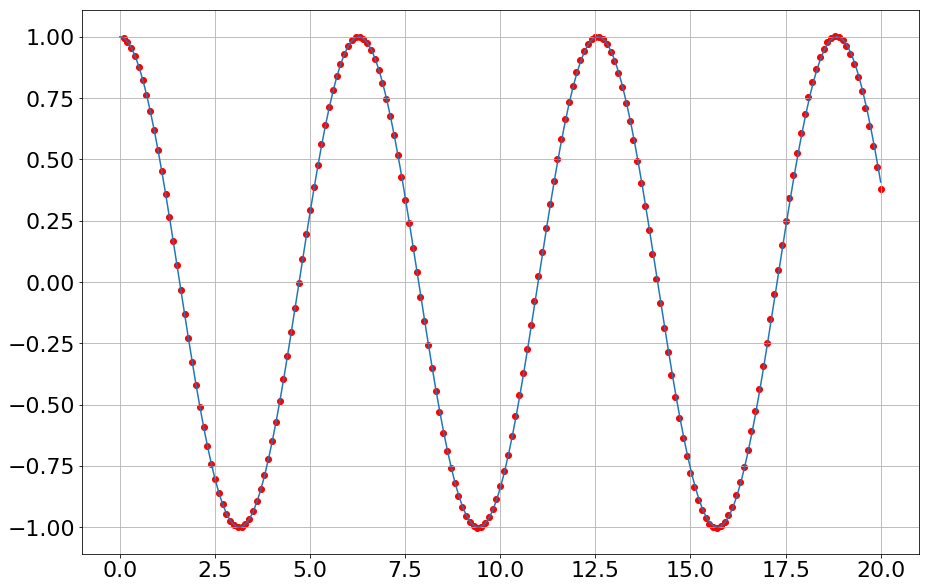

In [15]:
x = np.linspace(0,20,400)
y = np.cos(x)

plt.grid(True)
plt.scatter(res[:,0], res[:,1], color='r')
plt.plot(x, y);